# Expectation value of the Hadamard test

Author: Hao Mack Yang

The purpose of this demonstration is to code the algorithm of the Hadamard test in Python Classiq. The Hadamard test is used to generate a quantum complex or real variable $|\psi\rangle$ using two applications of the Hadamard gate on the auxiliary qubit. The auxiliary qubit is initialized at $|0\rangle$, and controls the unitary gate targeting $|\psi\rangle$. The Hadamard test circuit will be tested using 1000 to 16000 shots, and the real part of the expectation value is calculated using the observed probabilities. Let $P_0$ denote the probability that the top qubit will return a $|0\rangle$ upon measurement, which is to be sampled.

 It follows that the real part of the expectation value is a linear function of the probability that can be exactly expressed in terms of the probability that the auxiliary qubit will return the zero state: $\mathfrak{R} \langle \psi | U | \psi \rangle = 2P_0 - 1$.

## Python implementation

We will code a Python Classiq implementation of the Hadamard test, using the quantum Fourier transform matrix as the unitary matrix, and with $| \psi \rangle$ initialized to the zero state $|0\rangle$ of $n$ qubits. The problem now becomes solving for $\mathfrak{R} \langle 0 | U_{\textrm{QFT}} | 0 \rangle = 2P_0 - 1$.

In [1]:
# Import and set default parameters
from classiq import *
QUBITS = 4

In [2]:
# Build the quantum circuit
@qfunc
def main(e: Output[QBit]):
	psi = QArray(name="ψ", element_type=QBit, length=QUBITS)
	allocate(QUBITS, psi) # Initialized to zero
	allocate(1, e)
	H(e) # Hadamard the top qubit
	control(ctrl=(e == 0), operand=lambda: qft(psi)) # Apply controlled QFT
	H(e) # Hadamard the top qubit again

In [4]:
# Run the quantum circuit in the SDK, with multiple trials
from classiq.execution import ExecutionPreferences
TRIALS = 100
quantum_model = create_model(main)
shotslist = [1000, 2000, 4000, 8000, 16000]
trialslist = []

for trial in range(TRIALS):
	# Build results list from each trial
	resultslist = []
	for shots in shotslist:
		quantum_model_with_execution_preferences = set_execution_preferences(
			quantum_model,
			ExecutionPreferences(
				num_shots=shots, job_name="classiq 6.8 {0:05d}".format(shots)
			),
		)
		quantum_program_with_execution_preferences = synthesize(
			quantum_model_with_execution_preferences
		)
		job = execute(quantum_program_with_execution_preferences)
		print(
			f"The job {trial} on the provider {job.provider} on the backend {job.backend_name} with {job.num_shots} shots is {job.status} can be accessed in the IDE with this URL: {job.ide_url}"
		)
		results = job.result()[0].value
		print("\t" + str(results))
		p0 = results.counts['0']/shots # Probability of observing zero state
		re = 2*p0 - 1                  # Real part of observable expectation under zero state
		print("\tThe probability of observing state zero is {0:.3f}. The real part of the expectation of the QFT observable is {1:.3f}.".format(p0, re) )
		print()
		resultslist.append((results, p0, re))
	trialslist.append(resultslist)

The job 0 on the provider Classiq on the backend simulator with 1000 shots is QUEUED can be accessed in the IDE with this URL: https://platform.classiq.io/jobs/b0fcbb29-64da-4ce5-8bfa-8130f5cde1ed
	vendor_format_result={} counts={'0': 636, '1': 364} counts_lsb_right=True parsed_states={'0': {'e': 0.0}, '1': {'e': 1.0}} histogram=None output_qubits_map={'e': (0,)} state_vector=None parsed_state_vector_states=None physical_qubits_map={'e': (0,)} num_shots=1000
	The probability of observing state zero is 0.636. The real part of the expectation of the QFT observable is 0.272.

The job 0 on the provider Classiq on the backend simulator with 2000 shots is QUEUED can be accessed in the IDE with this URL: https://platform.classiq.io/jobs/81dbb220-17aa-4f4f-b22e-c4e963805054
	vendor_format_result={} counts={'1': 752, '0': 1248} counts_lsb_right=True parsed_states={'1': {'e': 1.0}, '0': {'e': 0.0}} histogram=None output_qubits_map={'e': (0,)} state_vector=None parsed_state_vector_states=None phy

## Theoretical value and graphing

In theory, the probability of the first qubit being in the zero state is exactly $\frac{5}{4}$. This implies that the real part of the expectation of $|\psi\rangle$ is exactly $\frac{1}{4}$.

### Derivation

Apply the Hadamard gate to the control qubit. The state just before applying the controlled unitary is $|+\rangle |\psi\rangle = \frac{|0\rangle|\psi\rangle + |1\rangle|\psi\rangle}{\sqrt{2}}$.

Apply the controlled unitary gate to the target qubit. The state after applying the controlled unitary is $\frac{|0\rangle|\psi\rangle + |1\rangle U |\psi\rangle}{\sqrt{2}}$.

Apply the Hadamard gate again to the control qubit. The final state before measurement is $\frac{|+\rangle|\psi\rangle + |-\rangle U |\psi\rangle}{\sqrt{2}} = \frac{|0\rangle|\psi\rangle + |1\rangle|\psi\rangle + |0\rangle U |\psi\rangle - |1\rangle U |\psi\rangle}{2}$.

This expression can be factored to $\frac{|0\rangle(I + U)|\psi\rangle + |1\rangle(I - U)|\psi\rangle}{2}$. The probability of obtaining result $|0\rangle$ in the target qubit is the inner product of the coefficient $\frac{|\psi\rangle + U|\psi\rangle}{2}$. The probability is thus: $$ P_0 = \frac{\langle\psi|(I + U^\dagger)(I + U)|\psi\rangle}{4} = \frac{\langle\psi|(2I + U^\dagger + U)|\psi\rangle}{4} $$

### Derivation for QFF under the zero state

Let $N = 2^n$. In this problem, $|\psi\rangle = |1,0^{\otimes N - 1}\rangle$, represented as a one-hot column vector where the first entry is unity. $U = U_{\textrm{QFF}}$ is a $N \times N$ matrix where the first row and the first column consists entirely of ones, besides the common factor of $\sqrt{N} = 2^{n/2}$. 

Only the first column of $U_{\textrm{QFF}}$ is involved in the matrix multiplication; all others can be ignored to zero.

$$ \frac{1}{\sqrt{N}} \begin{bmatrix} 1 & 1 & \cdots & 1 \\ 1 & * & * & *  \\ \vdots & * & * & * \\ 1 & * & * & * \end{bmatrix}\begin{bmatrix} 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix} 
= \frac{1}{\sqrt{N}}\begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}$$

The first column of $I + U_{\textrm{QFF}}$ differs only by the very first entry, which is greater than all the other entries of the first row by exactly unity. 

$$ \begin{bmatrix} 1 + \frac{1}{\sqrt{N}} & \frac{1}{\sqrt{N}} & \cdots & \frac{1}{\sqrt{N}} \\ \frac{1}{\sqrt{N}} & * & * & *  \\ \vdots & * & * & * \\ \frac{1}{\sqrt{N}} & * & * & * \end{bmatrix}\begin{bmatrix} 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix} 
= \begin{bmatrix} 1 + \frac{1}{\sqrt{N}} \\ \frac{1}{\sqrt{N}}  \\ \vdots \\ \frac{1}{\sqrt{N}} \end{bmatrix}$$

Applying $U_{\textrm{QFF}}$ to $|1,0^{\otimes N - 1}\rangle$ results in the real ket $ U|\psi\rangle = |(1 + \frac{1}{\sqrt{N}}), \frac{1}{\sqrt{N}}^{\otimes N - 1}\rangle$. 

Apply the inner product with the previous result, we obtain $\langle\psi|(I + U^\dagger)(I + U)|\psi\rangle = (1 + \frac{2}{\sqrt{N}} + \frac{1}{N}) + (N - 1)\frac{1}{N} = 2 + \frac{2}{\sqrt{N}} = 2(1 + 2^{-n/2})$.

For $n = 4$, we have $\langle\psi|(I + U^\dagger)(I + U)|\psi\rangle = 2(1 + 2^{-2}) = 2(1 + \frac{1}{4}) = 2\cdot\frac{5}{4} = \frac{5}{2}$. It follows that $P_0 = \frac{5}{8}$. Because the real part of the expectation is a linear function of $P_0$ given by $\mathfrak{R} \langle 0 | U_{\textrm{QFT}} | 0 \rangle = 2P_0 - 1$, this expectation is exactly $\frac{5}{4} - 1 = \frac{1}{4}$. $\blacksquare$

Accordingly, if the number of qubits are odd, then $P_0$ and thus $\mathfrak{R} \langle 0 | U_{\textrm{QFT}} | 0 \rangle = 2P_0 - 1$ become irrational.

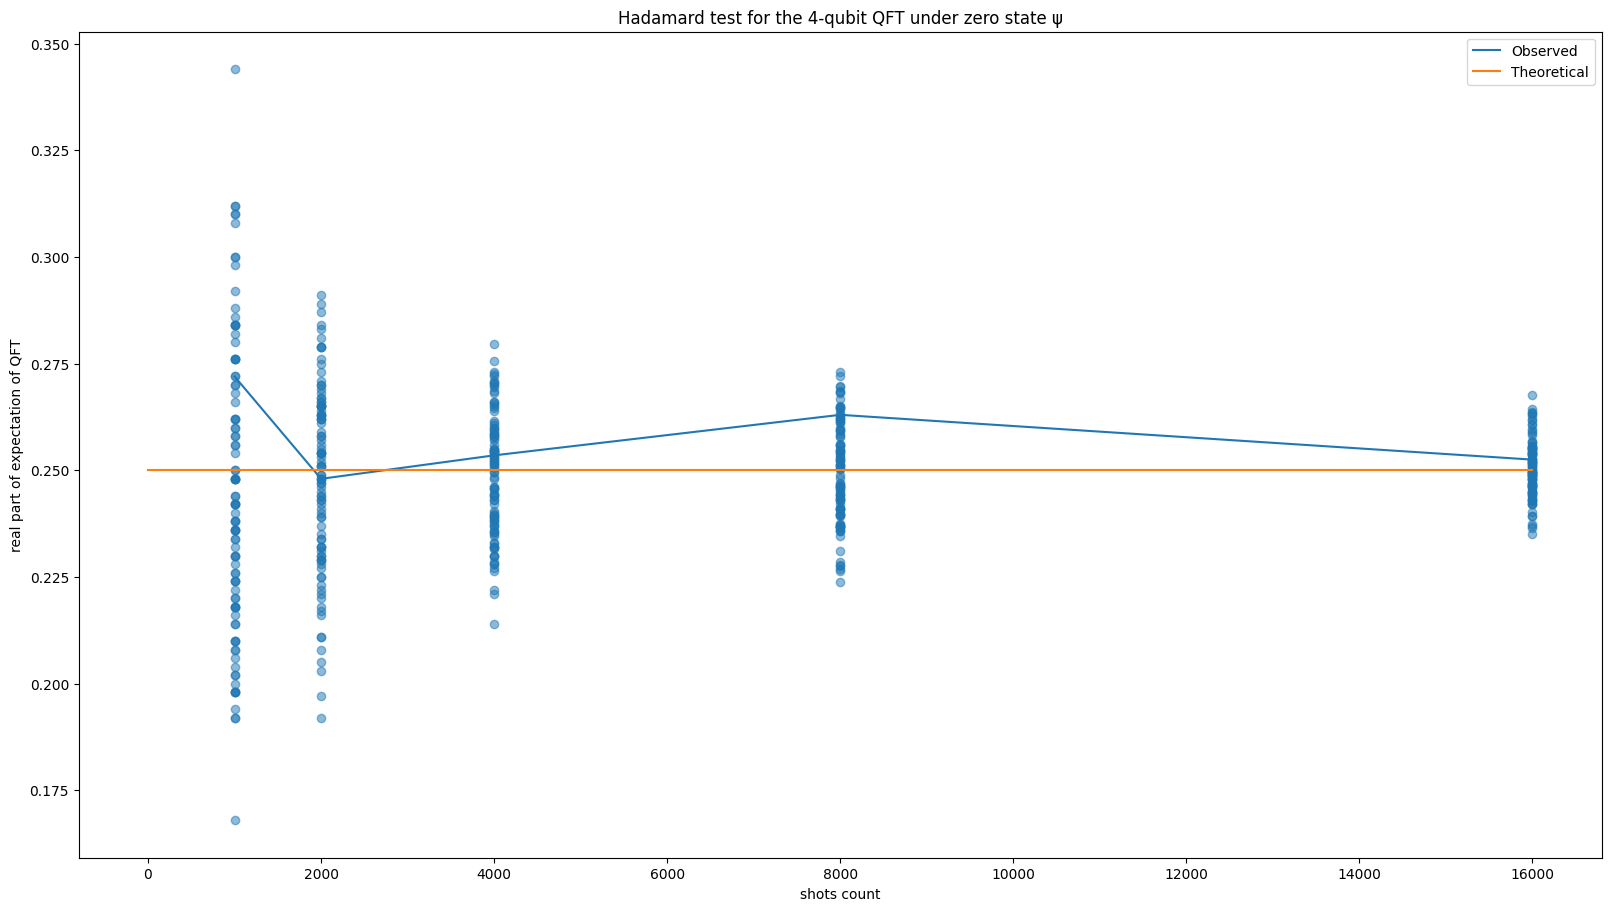

In [5]:
import matplotlib.pyplot as plt
# Determine theoretical value
theor = 0.250

# Plot the graph
fig, axs = plt.subplot_mosaic([['hadamard-qft']], layout='constrained', figsize=(16,9))
ax = axs['hadamard-qft']
ax.set_xscale('linear')
obs, = ax.plot(shotslist, list(map(lambda results : results[2], trialslist[0])), c="tab:blue")
for resultslist in trialslist[1:]:
	ax.scatter(shotslist, list(map(lambda results : results[2], resultslist)), c="tab:blue", alpha=0.5)
theorx, = ax.plot([0, max(shotslist)], [0.250, 0.250], c="tab:orange")
ax.set_xlabel('shots count')
ax.set_ylabel('real part of expectation of QFT')
ax.set_title('Hadamard test for the {0:d}-qubit QFT under zero state ψ'.format(QUBITS))
ax.legend([obs, theorx], ['Observed', 'Theoretical'])
plt.show()

## Conclusion

The graph above shows the estimated real part of the expectation from the observed probability across a hundred trials with 1000, 2000, 4000, 8000, and 16000 shots. There is a noticably smaller spread among the trials with 16000 shots compared to the trials with 1000 shots. The blue line is the estimates of the expectation from the first trial, though the five jobs are still independent.

The convergence of the Hadamard test results is consistent with the theoretical value of the real part of the expectation of $|\psi\rangle$ under the quantum Fourier transform, as demonstrated by running the four-qubit QFT from 1000 to 16000 shots and observing the probability that the control qubit collapses to the zero state.